In [12]:
dataname="trg-multi-7classes"

resize_resolutions=[1,.25] #resize input image, base and second

patch_size=128 #size of the tiles to extract and save in the database, must be >= to training size
patch_size_res2 = int(patch_size  * 1/resize_resolutions[1])
mirror_pad_size = patch_size_res2


test_set_size=.1 # what percentage of the dataset should be used as a held out validation/testing set
class_names=["Fat", "Muscular", "Vein", "Gland", "Stroma", "Tumor", "Epithelium"]

#-- relating to masks
#max_number_samples={"train":5000,"val":100}
max_number_samples={"train":500,"val":100}
phases=['train','val'] 

In [13]:
def random_subset(a, b, nitems):
    assert len(a) == len(b)
    idx = np.random.randint(0,len(a),nitems)
    return a[idx], b[idx]

In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

In [4]:
import torch
import tables

import os,sys
import glob

import PIL
import numpy as np

import cv2
import matplotlib.pyplot as plt

import scipy.signal

from sklearn import model_selection
import sklearn.feature_extraction.image
import random

from collections import Counter

from tqdm.autonotebook import tqdm

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 2439370506019401831


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 

In [8]:
files=glob.glob('../../data/raw/*mask.png')
#create training and validation stages and split the files appropriately between them

In [9]:
files

['../../data/raw/slide-2019-09-24T09-59-19-R1-S3.mrxs_Tumor_(4.00,62442,78320,7257,9303)-mask.png',
 '../../data/raw/slide-2019-09-24T10-28-23-R1-S12.mrxs_Stroma_(4.00,30101,30382,2109,1972)-mask.png',
 '../../data/raw/slide-2019-09-24T10-30-41-R1-S13.mrxs_Stroma_(4.00,43103,99575,2940,2690)-mask.png',
 '../../data/raw/slide-2019-09-24T10-15-55-R1-S8.mrxs_Epithelium_(4.00,6642,69128,3468,4098)-mask.png',
 '../../data/raw/slide-2019-09-24T09-56-00-R1-S2.mrxs_Gland_(4.00,10136,122283,1657,2823)-mask.png',
 '../../data/raw/slide-2019-09-24T10-15-55-R1-S8.mrxs_Fat_(4.00,48507,75523,5302,3484)-mask.png',
 '../../data/raw/slide-2019-09-24T10-40-49-R1-S16.mrxs_Stroma_(4.00,33732,86027,1415,2174)-mask.png',
 '../../data/raw/slide-2019-09-24T09-56-00-R1-S2.mrxs_Muscular_(4.00,48168,139446,1701,1494)-mask.png',
 '../../data/raw/slide-2019-09-24T09-52-40-R1-S1.mrxs_Epithelium_(4.00,13723,93933,771,1303)-mask.png',
 '../../data/raw/slide-2019-09-24T09-59-19-R1-S3.mrxs_Muscular_(4.00,44168,85360,12

In [10]:
img = cv2.imread(files[0])
img.shape[0]
min(1, np.Infinity)

1

In [11]:
def min_dim(files):
    h, w = np.Infinity, np.Infinity
    for file in files: 
        img = cv2.imread(file)
        h = min(h, img.shape[0])
        w = min(w, img.shape[1])
    return h, w
min_dim(files)    

(78, 80)

In [17]:
storage={} #holder for future pytables

block_shape=np.array((patch_size,patch_size,3)) #block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed

for phase in phases: #now for each of the phases, we'll loop through the files
    print(phase)
    
    
    hdf5_file = tables.open_file(f"../../data/processed/{dataname}-{phase}.pytable", mode='w') #open the respective pytable
    storage["filenames"] = hdf5_file.create_earray(hdf5_file.root, 'filenames', filenameAtom, (0,)) #create the array for storage
    
    
    storage["imgres1"]= hdf5_file.create_earray(hdf5_file.root, "imgres1", img_dtype, shape=np.append([0],block_shape), 
                                                chunkshape=np.append([1],block_shape), filters=filters)
    
    storage["imgres2"]= hdf5_file.create_earray(hdf5_file.root, "imgres2", img_dtype,  shape=np.append([0],block_shape), 
                                                chunkshape=np.append([1],block_shape), filters=filters)
    
    storage["labels"]= hdf5_file.create_earray(hdf5_file.root, "labels", img_dtype, shape=[0],  chunkshape=[1], filters=filters)

    
    for fname_mask in tqdm(files): #now for each of the files
        classid=[idx for idx in range(len(class_names)) if class_names[idx] in fname_mask][0]

        
        img = cv2.cvtColor(cv2.imread(fname_mask.replace("-mask.png",".png")),cv2.COLOR_BGR2RGB)
        img= cv2.resize(img,(0,0),fx=resize_resolutions[0],fy=resize_resolutions[0], interpolation=PIL.Image.BICUBIC) #resize it as specified above
        img = np.pad(img, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
        
                
        mask = cv2.imread(fname_mask)
        mask = cv2.resize(mask,(0,0),fx=resize_resolutions[0],fy=resize_resolutions[0], interpolation=PIL.Image.NEAREST) #resize it as specified above
        mask=mask[:,:,0].squeeze()/255
        
        mask = np.pad(mask, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size)], mode="constant", constant_values =255 )

        
        [rs,cs]=np.logical_and(mask!=255, mask).nonzero()

        [rs,cs]=random_subset(rs,cs,min(max_number_samples[phase],len(rs)))
        
        for i, (r,c) in tqdm(enumerate(zip(rs,cs)),total =len(rs), leave=False):

            r=int(r)
            c=int(c)

            imgres1 = img[r-patch_size//2:r+patch_size//2,c-patch_size//2:c+patch_size//2,:]
            
            imgres2 = img[r-patch_size_res2//2:r+patch_size_res2//2,c-patch_size_res2//2:c+patch_size_res2//2,:]
            imgres2 = cv2.resize(imgres2,(patch_size,patch_size), interpolation=PIL.Image.BICUBIC) #resize it as specified above


            storage["imgres1"].append(imgres1[None,::])
            storage["imgres2"].append(imgres2[None,::])

            storage["labels"].append([int(classid)]) #add the filename to the storage array
            storage["filenames"].append([fname_mask]) #add the filename to the storage array
            
        
    npixels=hdf5_file.create_carray(hdf5_file.root, 'classsizes',  tables.UInt64Atom(), (1,len(class_names)))
    totals=Counter(storage["labels"][:])
    npixels[:]=[ totals[x] for x in range(len(class_names))]
    hdf5_file.close()

train



val


In [19]:
hdf5_file.close()

In [21]:
db = tables.open_file(f"../../data/processed/{dataname}-train.pytable")

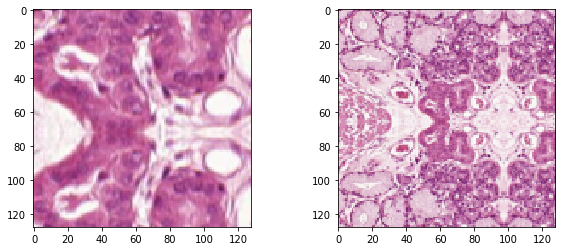

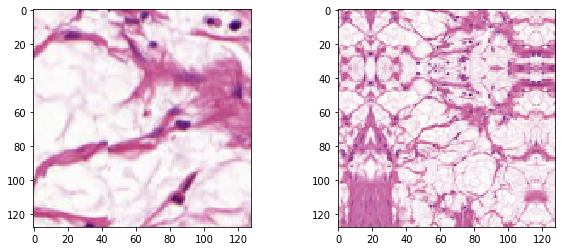

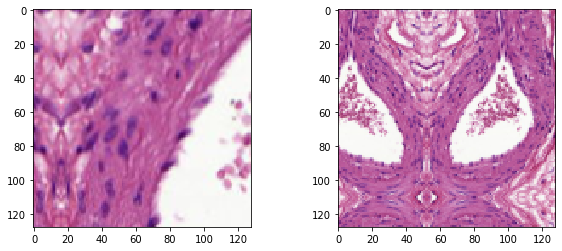

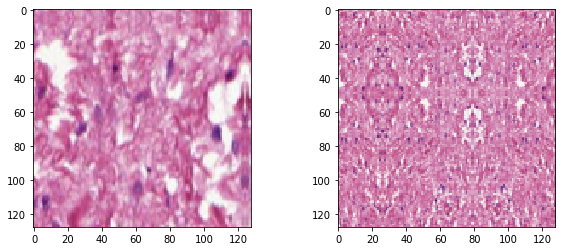

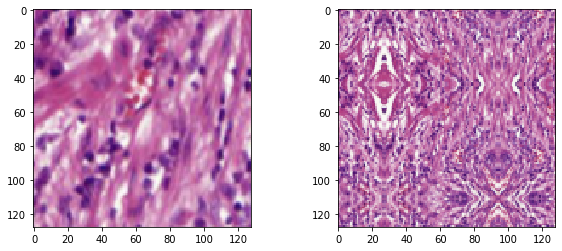

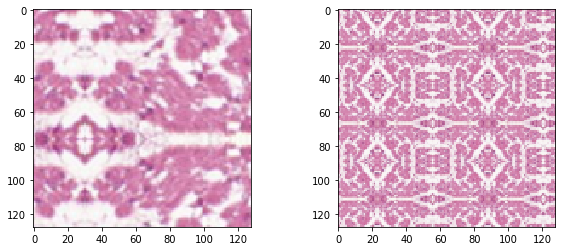

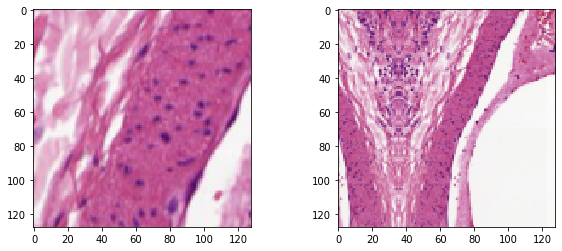

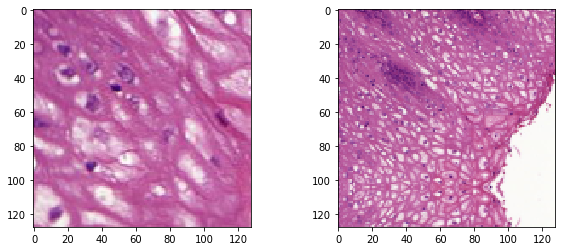

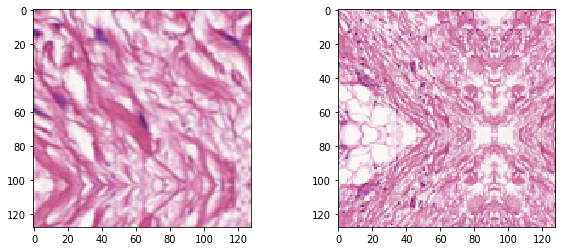

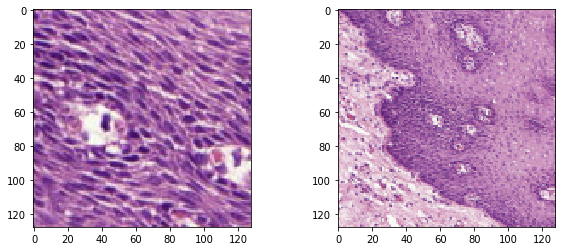

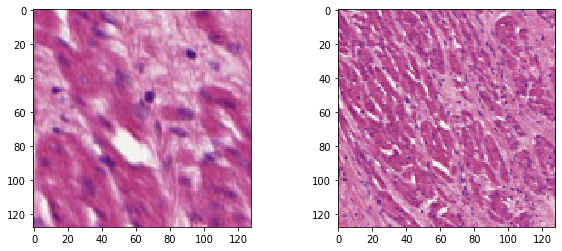

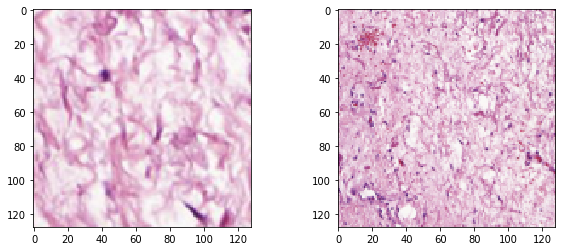

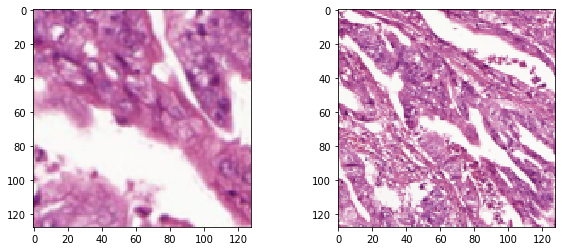

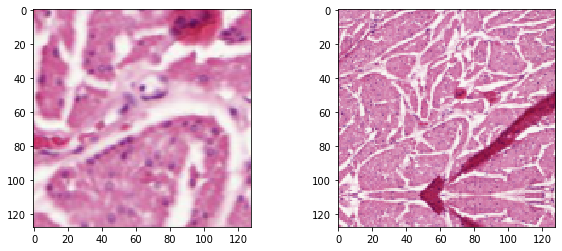

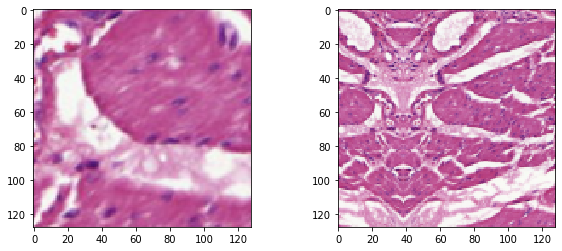

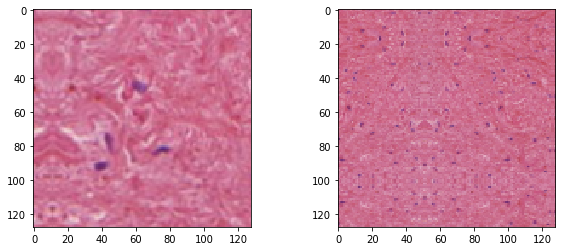

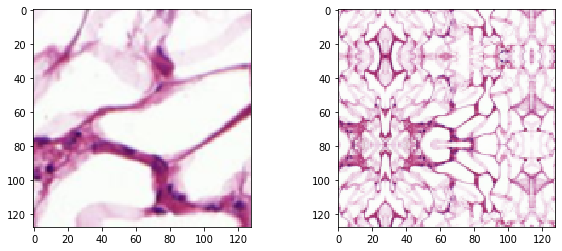

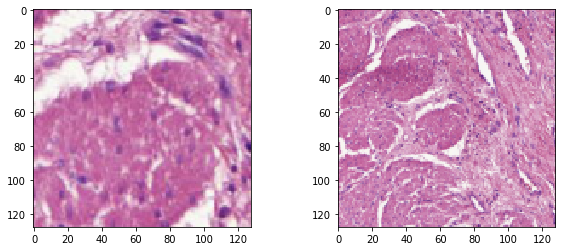

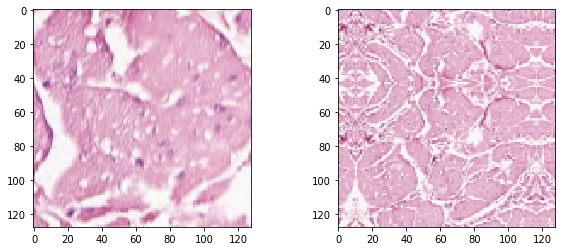

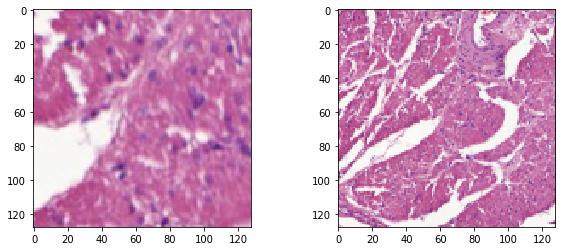

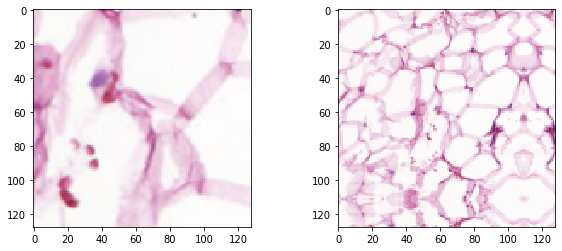

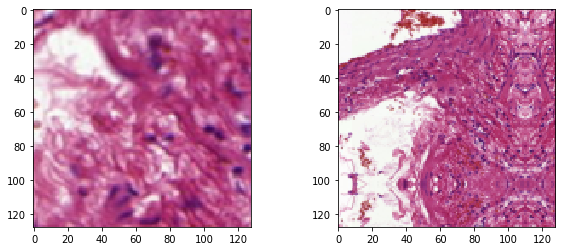

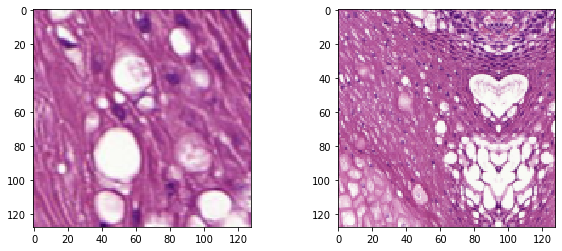

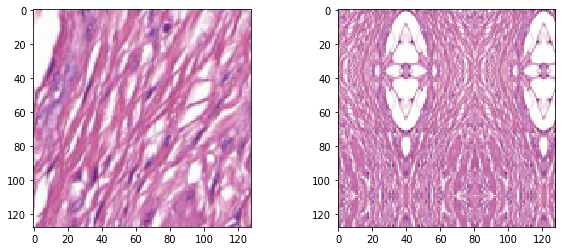

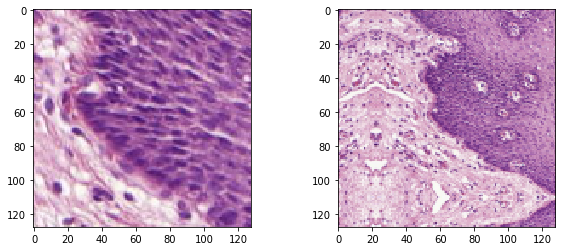

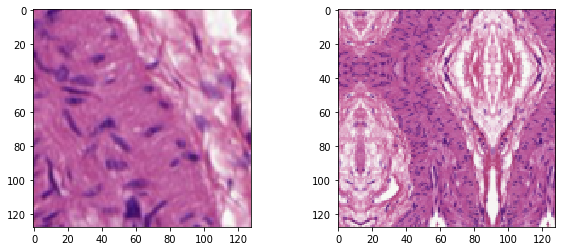

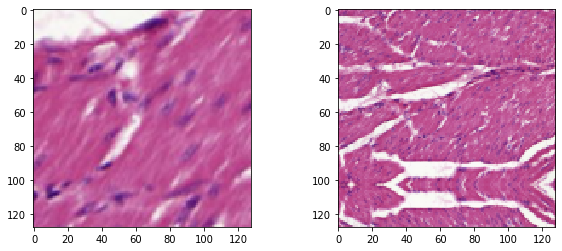

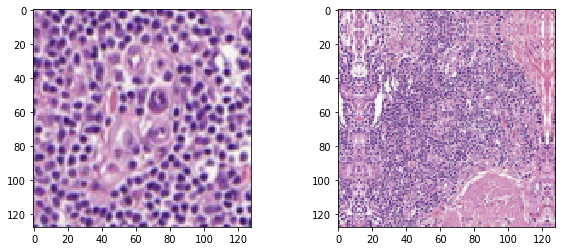

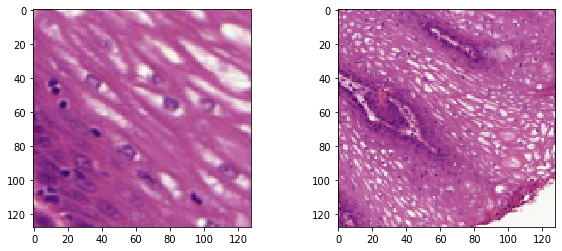

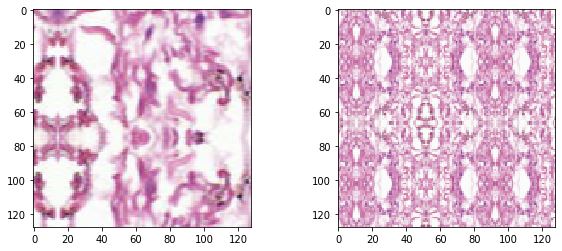

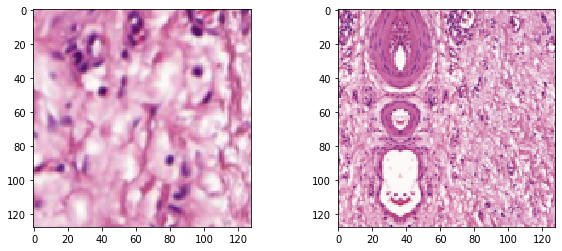

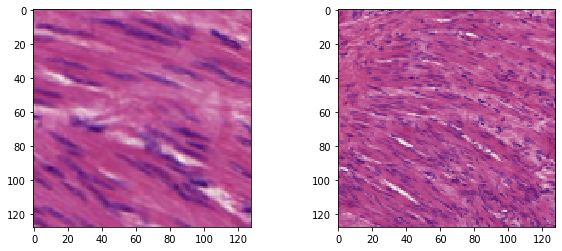

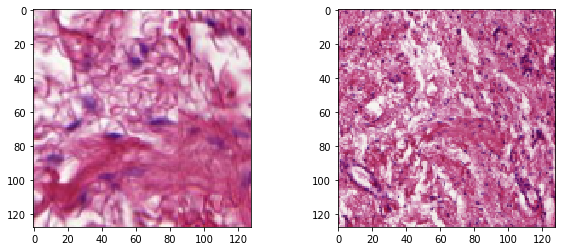

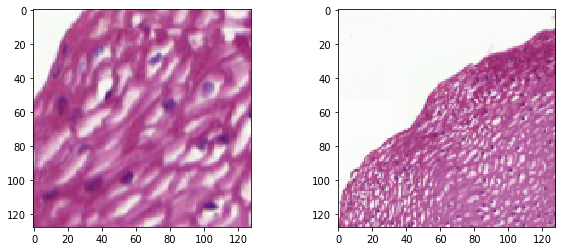

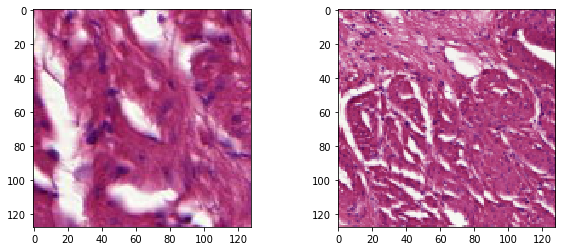

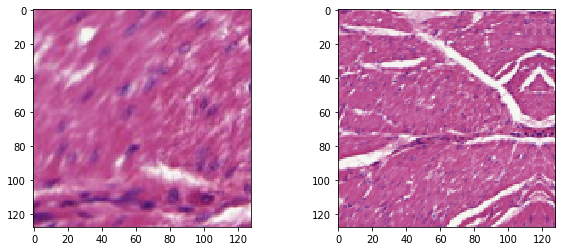

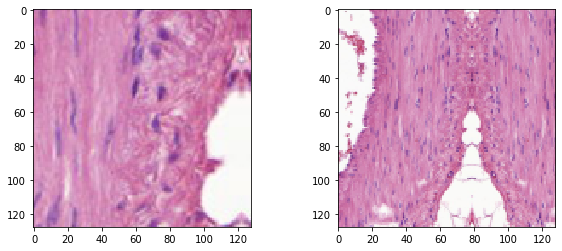

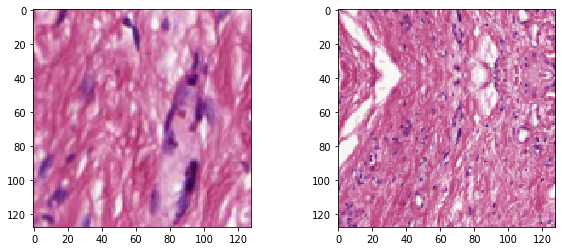

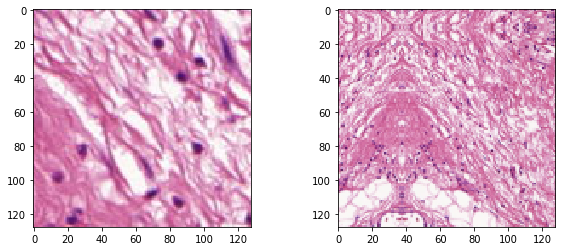

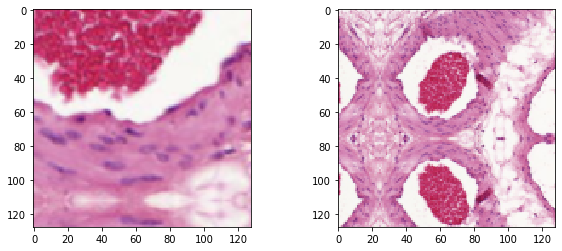

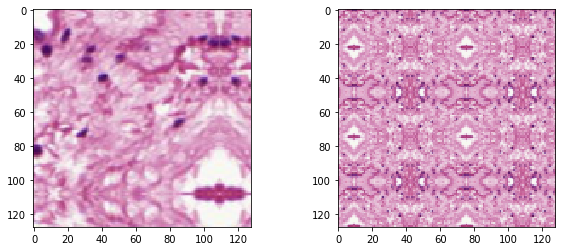

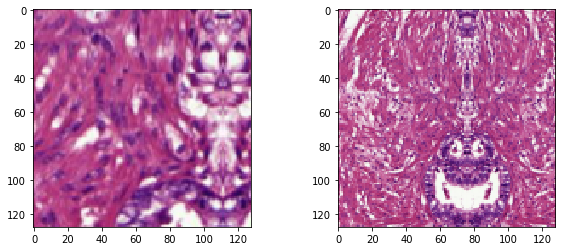

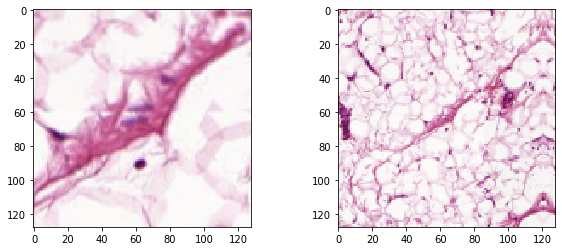

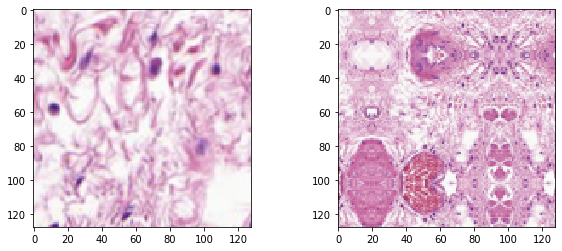

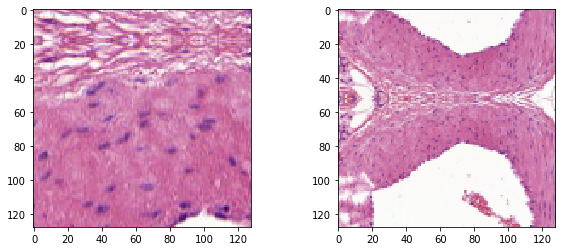

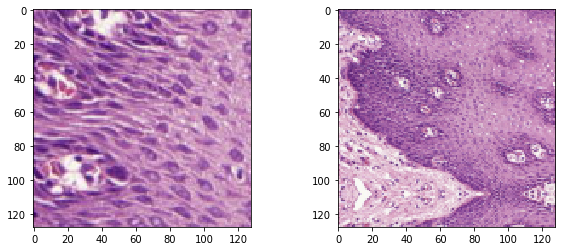

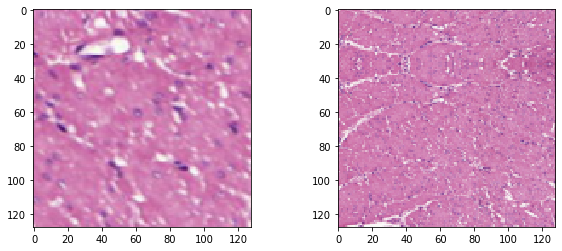

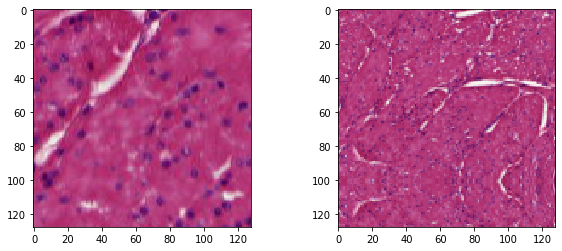

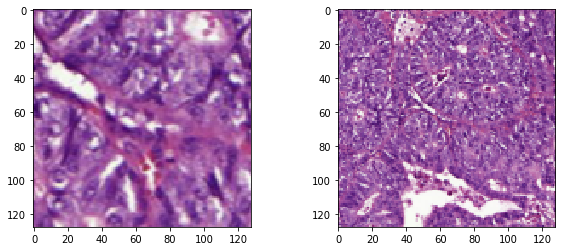

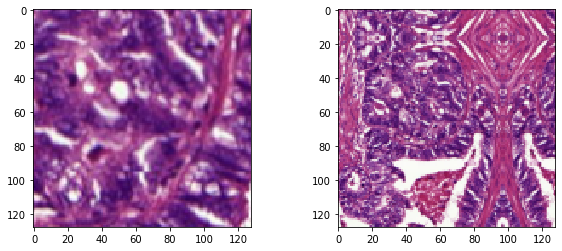

In [22]:
for idx in random.sample(range(len(db.root.labels)),50):
    imgres1=db.root.imgres1[idx,:,:,:].squeeze()
    imgres2=db.root.imgres2[idx,:,:,:].squeeze()
    fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
    ax[0].imshow(imgres1)
    ax[1].imshow(imgres2)
    plt.show()

In [28]:
db.close()